## Creating main dataset to standardize for the Final Jupyter Notebook

Needs to have ROI, Budgets, and Runntime

In [1]:
### Import the nessesary libraries
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

In [2]:
df_num = pd.read_csv('data/tn.movie_budgets.csv')

In [3]:
conn = sqlite3.connect('data/im.db')
q = """
SELECT 
    primary_title AS p_title,
    runtime_minutes AS time_min,
    averagerating AS avg_rating,
    genres
FROM movie_basics
JOIN movie_ratings
    USING(movie_id)
;
"""
df_IMDB = pd.read_sql(q, conn)

Combine the two into a single dataframe

In [4]:
### Merge on Primary Title
df = pd.merge(df_IMDB, 
            df_num, 
            how='inner', 
            left_on = 'p_title', 
            right_on = 'movie')
#df.info()

Cleaning the dataset

In [5]:
#Domestic
df['domestic_millions'] = df.domestic_gross.str.replace(',','')
df['domestic_millions'] = df.domestic_millions.str.replace('$','')
df['domestic_millions'] = pd.to_numeric(df.domestic_millions) / 1000000

#Worldwide
df['worldwide_millions'] = df.worldwide_gross.str.replace(',','')
df['worldwide_millions'] = df.worldwide_millions.str.replace('$','')
df['worldwide_millions'] = pd.to_numeric(df.worldwide_millions) / 1000000

# Get rid of non-numerics in production_budget
df['budget_millions'] = df.production_budget.str.replace(',','')
df['budget_millions'] = df.budget_millions.str.replace('$','')
df['budget_millions'] = pd.to_numeric(df.budget_millions) / 1000000


#df.info()

In [6]:
#Drop duplicates
df.drop_duplicates(subset=['movie'], inplace=True)
# df.head(10)

In [7]:
#df.info()

Adding in the correct roi

In [8]:
df['roi'] = (df.worldwide_millions - df.budget_millions)/df.budget_millions

Add in the binning for the production budget

In [9]:
def binning(x):
    if x > 216:
        return 216
    elif x > 108:
        return 108
    elif x > 64:
        return 64
    elif x > 32:
        return 32
    elif x > 16:
        return 16
    elif x > 8:
        return 8
    elif x > 4:
        return 4
    elif x > 2:
        return 2
    else:
        return 1

In [10]:
x = [binning(x) for x in df['budget_millions']]

In [11]:
pd.options.mode.chained_assignment = None
df['budget_binning'] = x

In [12]:
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2874
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   p_title             2126 non-null   object 
 1   time_min            2072 non-null   float64
 2   avg_rating          2126 non-null   float64
 3   genres              2124 non-null   object 
 4   id                  2126 non-null   int64  
 5   release_date        2126 non-null   object 
 6   movie               2126 non-null   object 
 7   production_budget   2126 non-null   object 
 8   domestic_gross      2126 non-null   object 
 9   worldwide_gross     2126 non-null   object 
 10  domestic_millions   2126 non-null   float64
 11  worldwide_millions  2126 non-null   float64
 12  budget_millions     2126 non-null   float64
 13  roi                 2126 non-null   float64
 14  budget_binning      2126 non-null   int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 265.8+

# Genre Z-Test Analysis

In [37]:
df = df.dropna()
myList = df['genres'].tolist()
genre_list=[]
for i in range(len(myList)):
    genre_list.append(myList[i].split(','))
#genre_list

In [38]:
from itertools import chain
genres=list(set(chain(*genre_list)))
#print(genres)
#print(len(genres))
#print(type(genres))

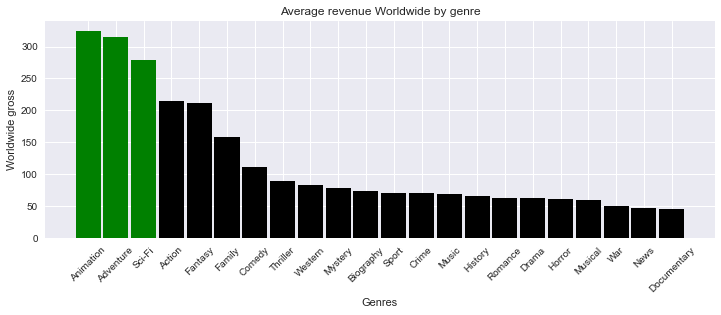

In [39]:
#Worldwide gross Average profits.

wwg_avg=[] 
for i in range(len(genres)):
    wwg = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    wwg_avg.append(df['worldwide_millions'][wwg].mean())

wwg_avg, genres = zip(*sorted(zip(wwg_avg, genres), reverse=True))  # reverse sort data on 'wwg_avg'
c = range(len(wwg_avg))

#creating the bar plot
clrs = ['black' if (x < wwg_avg[2]) else 'green' for x in wwg_avg ]
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(111)

ax.bar(c, wwg_avg, color=clrs ,width = 0.9)
plt.xticks(c, genres, rotation=45)
plt.xlabel("Genres")
plt.ylabel("Worldwide gross")
plt.title("Average revenue Worldwide by genre")
plt.show()

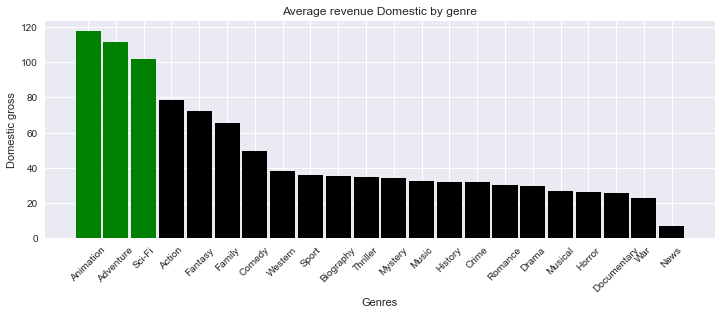

In [43]:
#Domestic gross Average profits.

dg_avg=[]
for i in range(len(genres)):
    dg = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    dg_avg.append(df['domestic_millions'][dg].mean())
#dg_avg
dg_avg, genres = zip(*sorted(zip(dg_avg, genres), reverse=True))
c = range(len(dg_avg))

#creating the bar plot
clrs = ['black' if (x < dg_avg[2]) else 'green' for x in dg_avg ]
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(111)

ax.bar(c, dg_avg, color=clrs ,width = 0.9)
plt.xticks(c, genres, rotation=45)
plt.xlabel("Genres")
plt.ylabel("Domestic gross")
plt.title("Average revenue Domestic by genre")
plt.show()

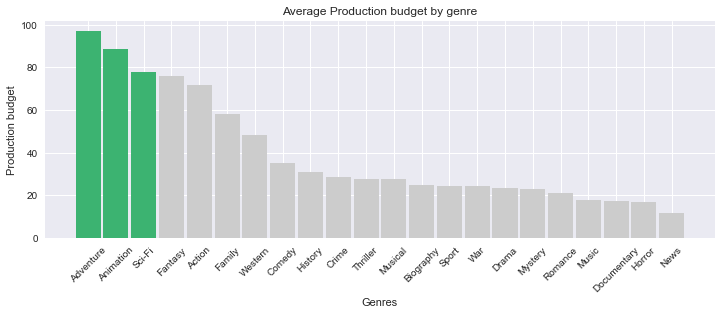

In [55]:
#production_budget Average profits.

pb_avg=[]
for i in range(len(genres)):
    pb = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    pb_avg.append(df['budget_millions'][pb].mean())
#print(pb_avg)

pb_avg, genres = zip(*sorted(zip(pb_avg, genres), reverse=True))
c = range(len(pb_avg))

#creating the bar plot
clrs = ['0.8' if (x < pb_avg[2]) else 'mediumseagreen' for x in pb_avg ]
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(111)

ax.bar(c, pb_avg, color=clrs ,width = 0.9)
plt.xticks(c, genres, rotation=45)
plt.xlabel("Genres")
plt.ylabel("Production budget")
plt.title("Average Production budget by genre")
plt.show()

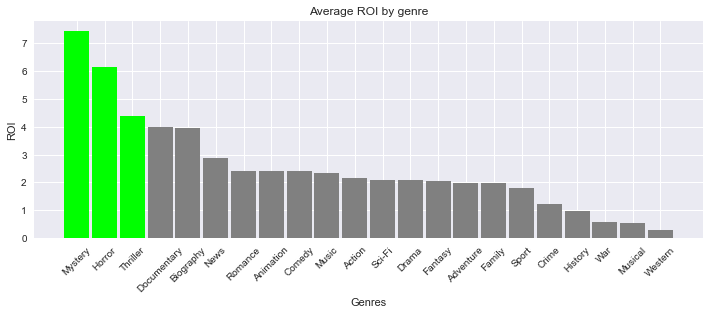

In [61]:
#Roi Average profits.

roi_avg=[]
for i in range(len(genres)):
    roi = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    roi_avg.append(df['roi'][roi].mean())
#print(roi_avg)
roi_avg, genres = zip(*sorted(zip(roi_avg, genres), reverse=True))
c = range(len(roi_avg))

#creating the bar plot
clrs = ['grey' if (x < wwg_avg[2]) else 'lime' for x in wwg_avg ]
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(111)

ax.bar(c, roi_avg, color=clrs ,width = 0.9)
plt.xticks(c, genres, rotation=45)
plt.xlabel("Genres")
plt.ylabel("ROI")
plt.title("Average ROI by genre")
plt.show()

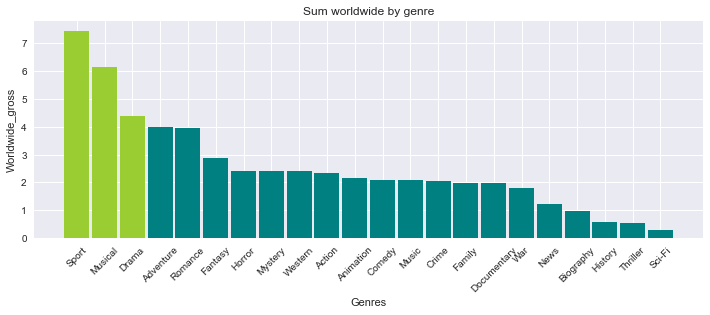

In [76]:
#Worldwide gross sum profits.

wwg_sum=[]
for i in range(len(genres)):
    Gsum = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    wwg_sum.append(df['worldwide_gross'][Gsum].sum())
#wwg_sum
wwg_sum, genres = zip(*sorted(zip(wwg_sum, genres), reverse=True))  # reverse sort data on 'wwg_avg'
c = range(len(roi_avg))

#creating the bar plot
clrs = ['#008080' if (x < wwg_sum[2]) else '#9ACD32' for x in wwg_sum ]
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(111)

ax.bar(c, roi_avg, color=clrs ,width = 0.9)
plt.xticks(c, genres, rotation=45)
plt.xlabel("Genres")
plt.ylabel("Worldwide_gross")
plt.title("Sum worldwide by genre")
plt.show()

## Hypothesis Testing

Our team wanted to see if Mystery, Horror and Thriller movies generete a larger ROI than other genres.

### State our Hypotheses:
H-Alt -> The average ROI for Mystery, Horror and Thriller is higher than other movies  $$\large H_a\text{:   }\mu < \bar{x}$$

H-Null -> There is no difference in the ROI for Mystery, , Horror and Thriller vs. other movies  $$\large H_o\text{:   }\mu \geq \bar{x}$$

Alpha: 0.05

In [19]:
df.describe()

,time_min,avg_rating,id,domestic_millions,worldwide_millions,budget_millions,roi,budget_binning
count,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.00000
mean,103.908213,6.228068,50.533333,46.721206,114.225849,37.497390,2.654110,27.05942
std,18.747006,1.130268,28.547208,78.051190,216.068937,51.466797,13.790324,37.08651
min,5.000000,1.600000,1.000000,0.000000,0.000000,0.001400,-1.000000,1.00000
25%,91.000000,5.600000,26.000000,0.641150,2.507165,5.000000,-0.625003,4.00000
50%,102.000000,6.300000,50.000000,18.964095,33.204586,19.000000,0.696789,16.00000
75%,114.000000,7.000000,75.000000,56.449204,116.736437,45.000000,2.644018,32.00000
max,180.000000,9.200000,100.000000,760.507625,2776.345279,425.000000,415.564740,216.00000


In [20]:
#population mean and std

roi_mean = df['roi'].mean()
roi_std = df['roi'].std()

stats.norm(roi_mean, roi_std)
plt.style.use('seaborn')

In [21]:
#Mystery mean
df_mystery = df[df['genres'].str.contains('Mystery')]
mystery_mean = df_mystery['roi'].mean()
#df_mystery
#print(mystery_mean)

#Horror mean
df_horror = df[df['genres'].str.contains('Horror')]
horror_mean = df_horror['roi'].mean()
#df_mystery
#print(mystery_mean)

#Thriller mean
df_thriller = df[df['genres'].str.contains('Thriller')]
thriller_mean = df_thriller['roi'].mean()
#df_mystery
#print(mystery_mean)

#Documentary mean
df_Documentary = df[df['genres'].str.contains('Documentary')]
Documentary_mean = df_Documentary['roi'].mean()
#df_mystery
#print(mystery_mean)

In [22]:
# Z score Function
from math import sqrt
def Zscore(Dataframe, mean):
    x_bar= mean
    n =  len(Dataframe.id)
    sigma = roi_std
    mu = roi_mean
    z = (x_bar - mu)/(sigma/sqrt(n))

    pval= 1-stats.norm.cdf(z)
    print(f'P-value: {pval}') 
    print(pval<0.05)
    print(f'Percent area under the curve from Zscore of {z} is {stats.norm.cdf(z)*100}% \n')
   
    
Zscore(df_mystery, mystery_mean)
Zscore(df_horror, horror_mean)
Zscore(df_thriller, thriller_mean)
Zscore(df_Documentary, Documentary_mean)

P-value: 4.619940964678548e-06
True
Percent area under the curve from Zscore of 4.434237277030223 is 99.99953800590353% 

P-value: 2.0679048268856803e-05
True
Percent area under the curve from Zscore of 4.099758791095601 is 99.99793209517311% 

P-value: 0.008758839449245048
True
Percent area under the curve from Zscore of 2.3756582508012034 is 99.12411605507549% 

P-value: 0.1475443516480548
False
Percent area under the curve from Zscore of 1.047023579203531 is 85.24556483519451% 



# Law of Diminishing Returns Analysis

# Runtime Analysis